In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, time, timedelta
from dateutil import parser
from matplotlib.lines import Line2D
import seaborn as sns
import os
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu

**Treinseries:**<br>
         1700: Enschede - Den Haag Centraal<br>
         7000: Almelo - Apeldoorn<br>
         7900: Enschede - Zwolle<br>
         3600: Zwolle - Roosendaal<br>
         31300: Amersfoort - Ede-Wageningen<br>
         31400: Amersfoort - Barneveld-Zuid<br>
         17900: Enschede - Zwolle IC<br>
         31200: Zutphen - Oldenzaal<br>
         1500: Deventer - Amsterdam

In [4]:
all_data_with_ICE_interaction = {}       #Dictionary with stations as keys, dataframe of domestic trains with interaction with ICE as values 
ICE_services = [140, 142, 144, 146, 148, 240, 242]      #Train service numbers of the ICE
stations = ['Hengelo', 'Deventer', 'Apeldoorn', 'Amersfoort Centraal']  #Stations with stops of the ICE within the scope
o_services = ['7900', '1700', '3600', '31300', '31400','1500', '31200', '7000', '17900'] #Considered services in the secondary delay analysis (other services)

file_s = f'Services/all_interesting_services_complete_day.csv'
df = pd.read_csv(file_s, sep = ',')

#Convert the time columns
df['Stop:Departure time'] = pd.to_datetime(df['Stop:Departure time'], utc=True, format='mixed', dayfirst=True)
df['Stop:Arrival time'] = pd.to_datetime(df['Stop:Arrival time'], utc=True, format='mixed', dayfirst=True)
df['Service:Date'] = pd.to_datetime(df['Service:Date'], format='mixed', dayfirst=True)


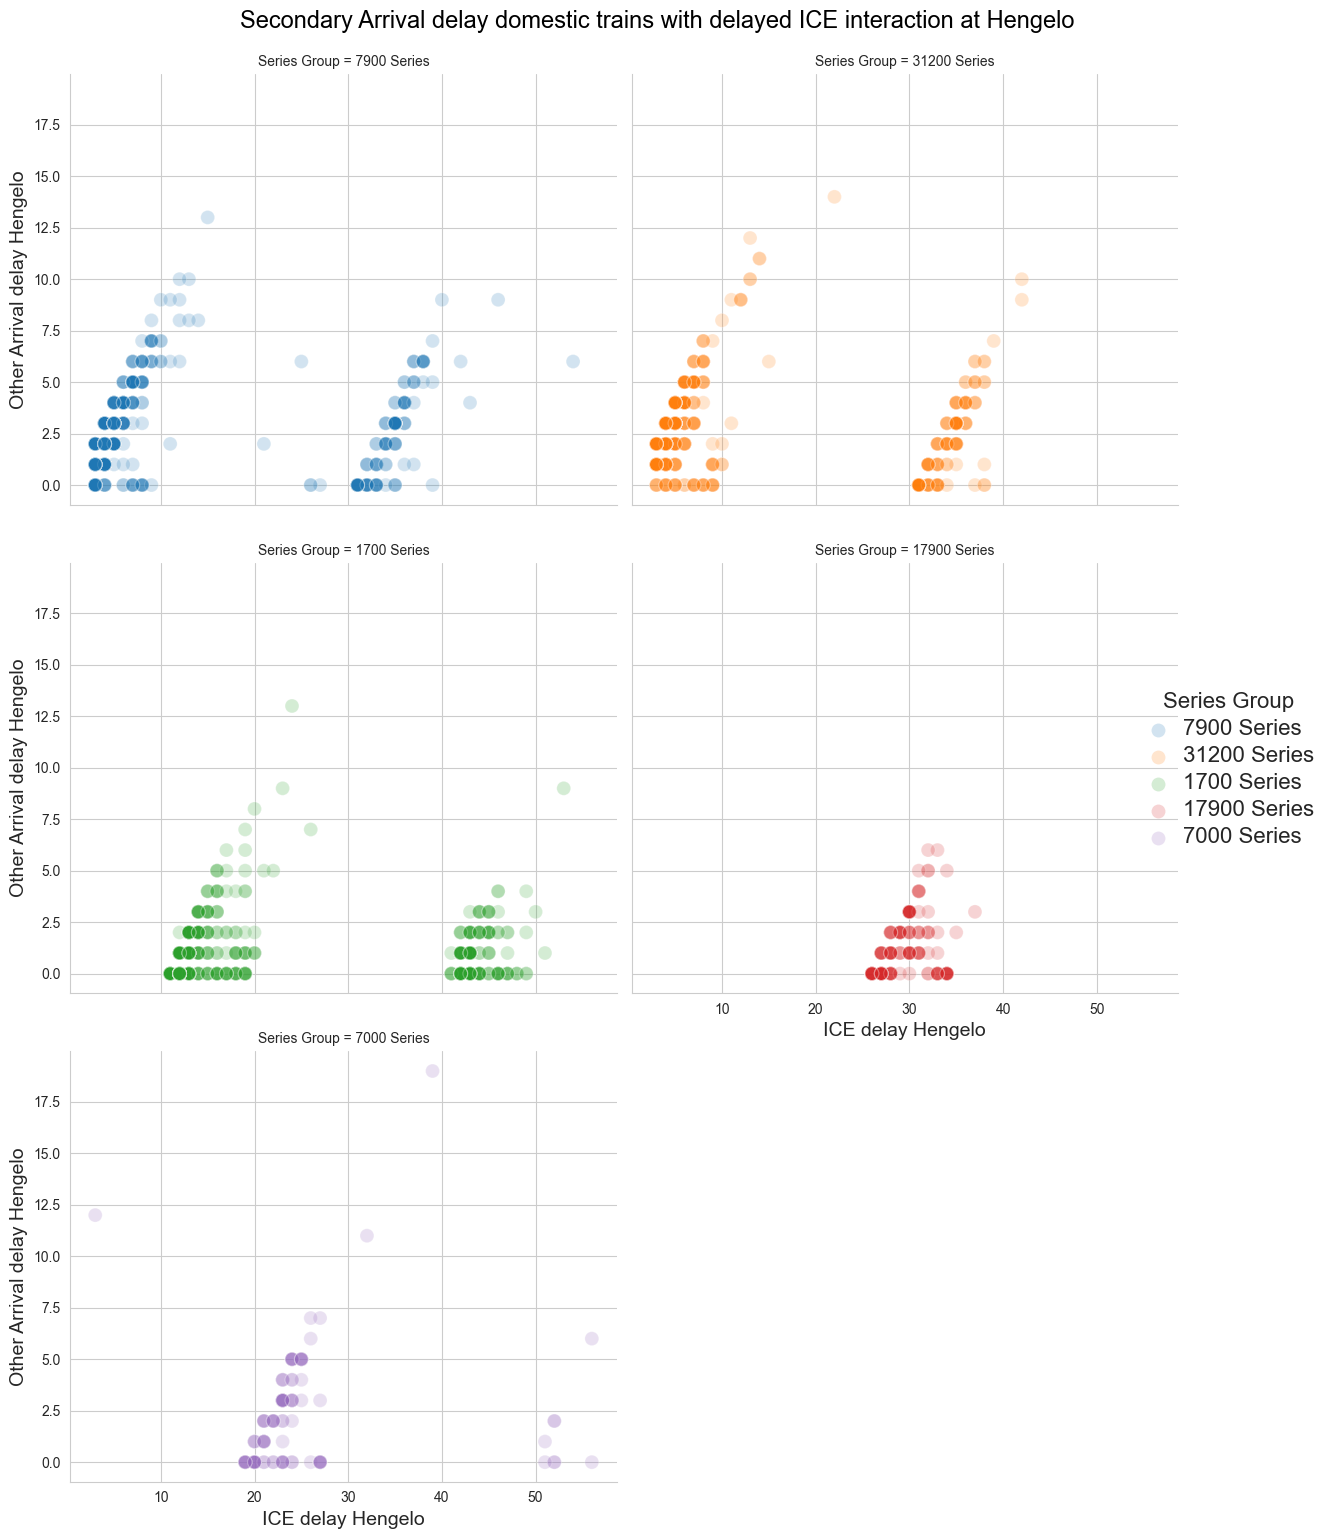

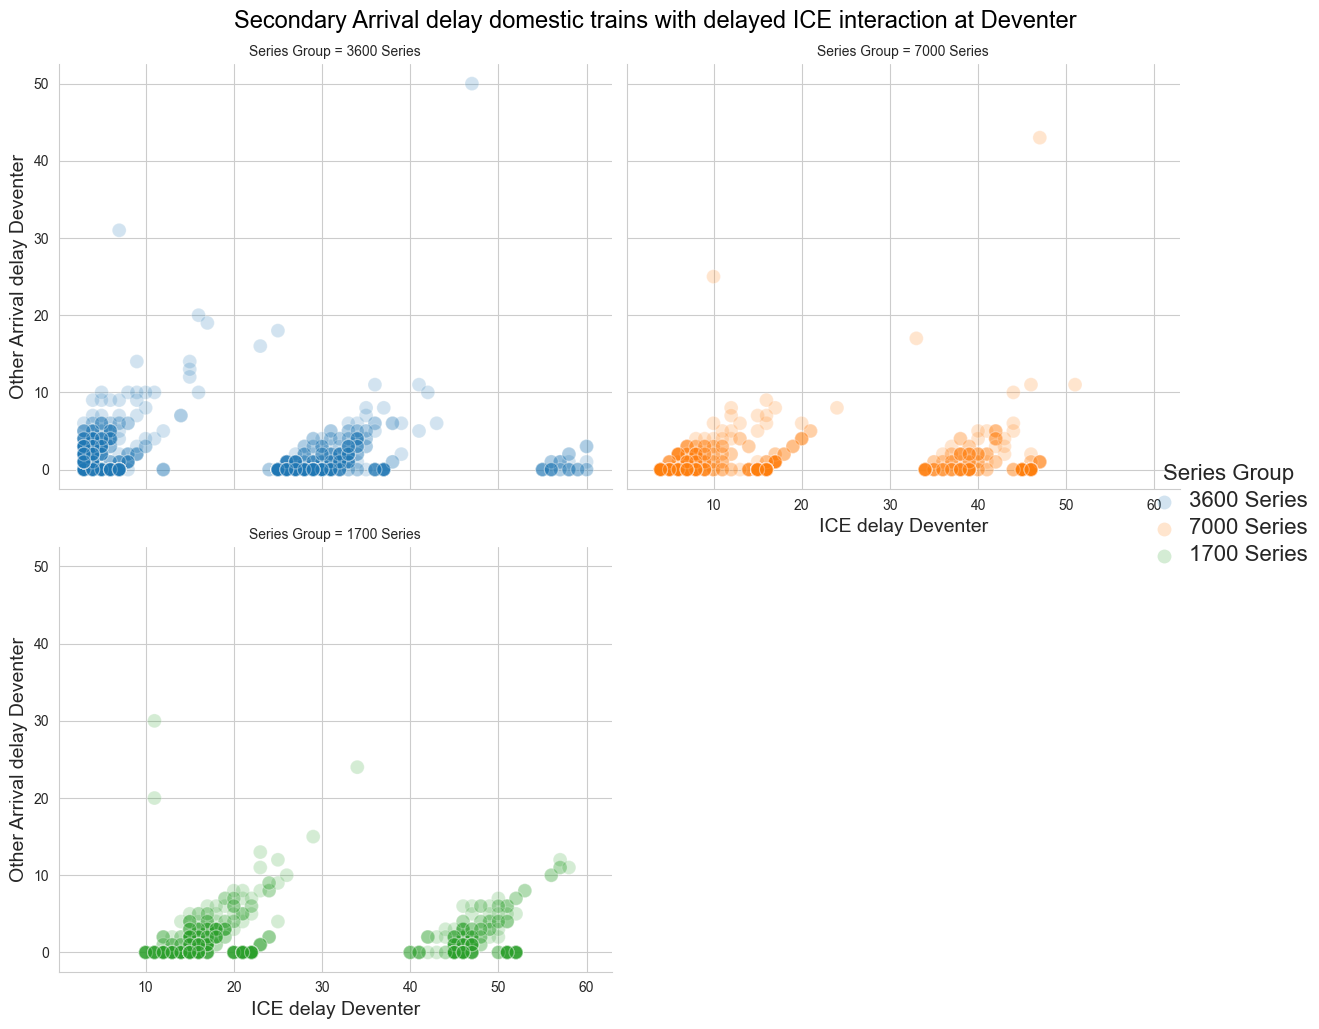

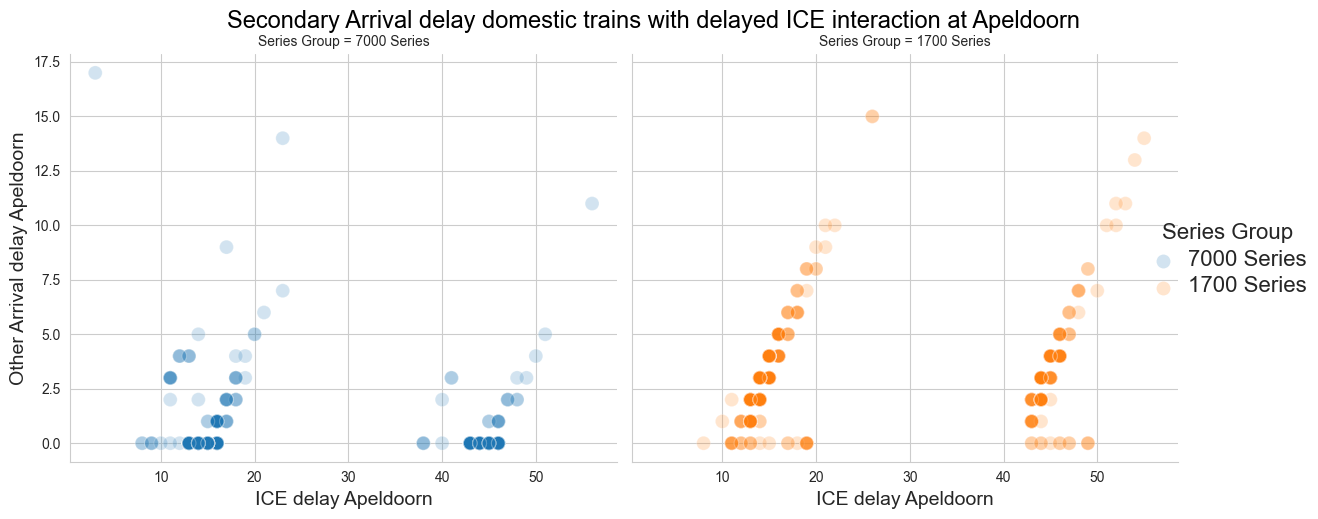

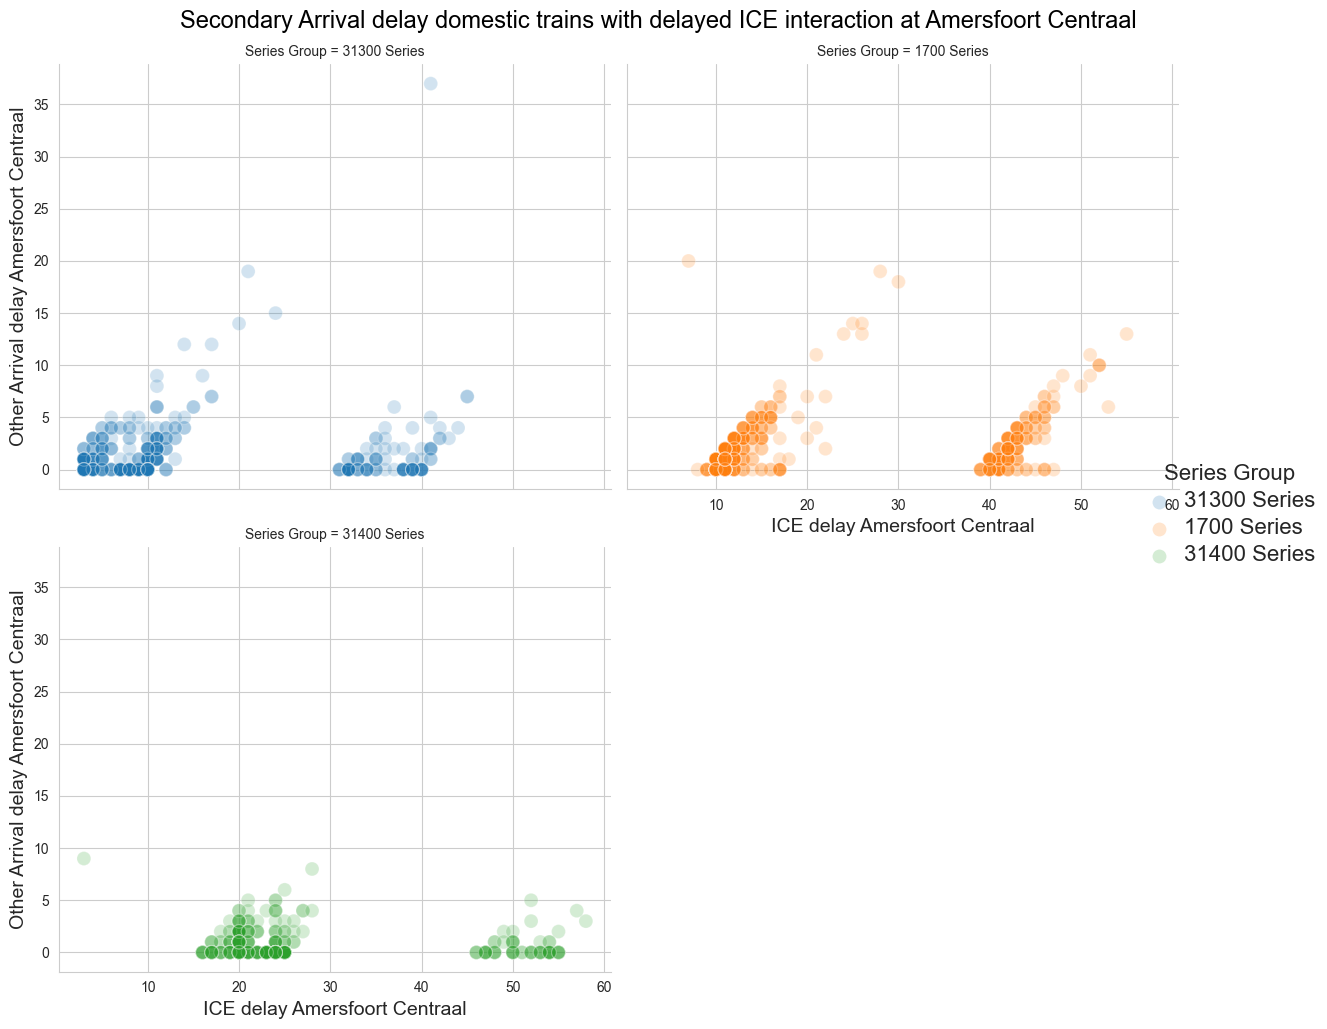

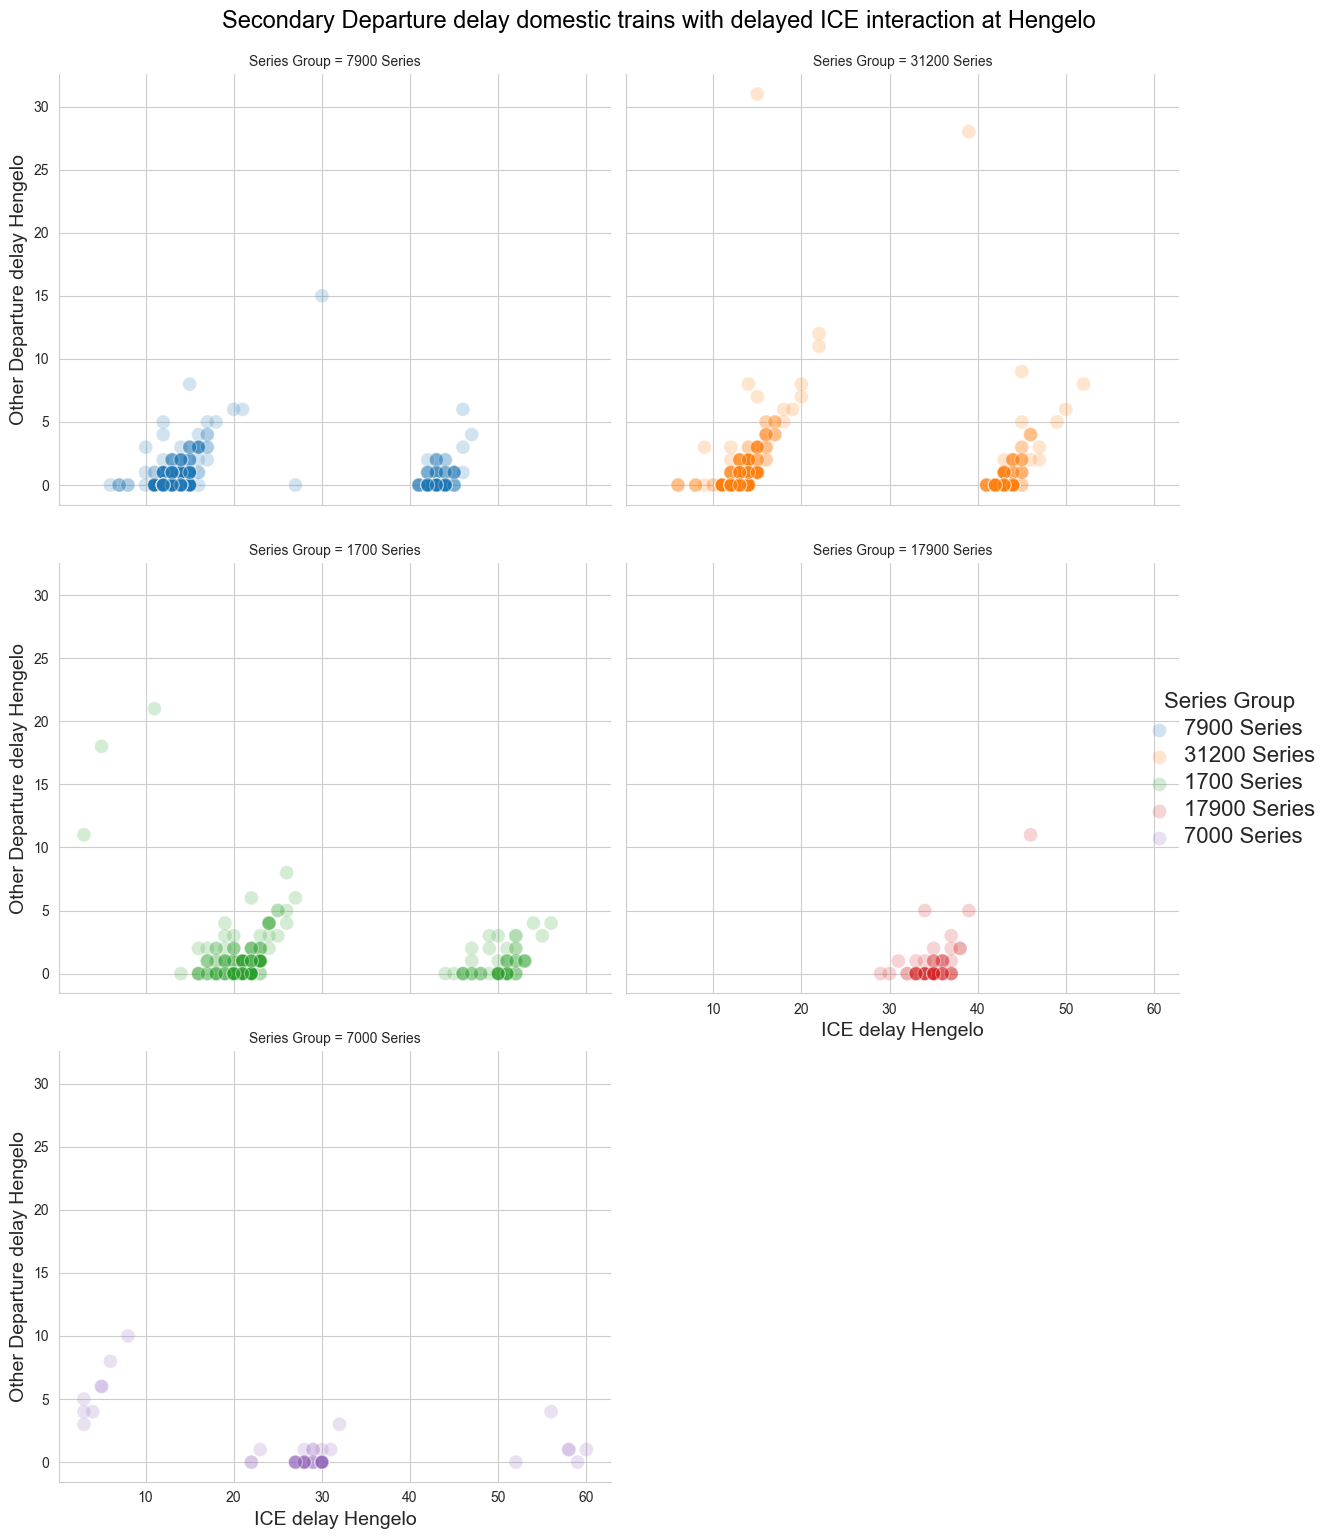

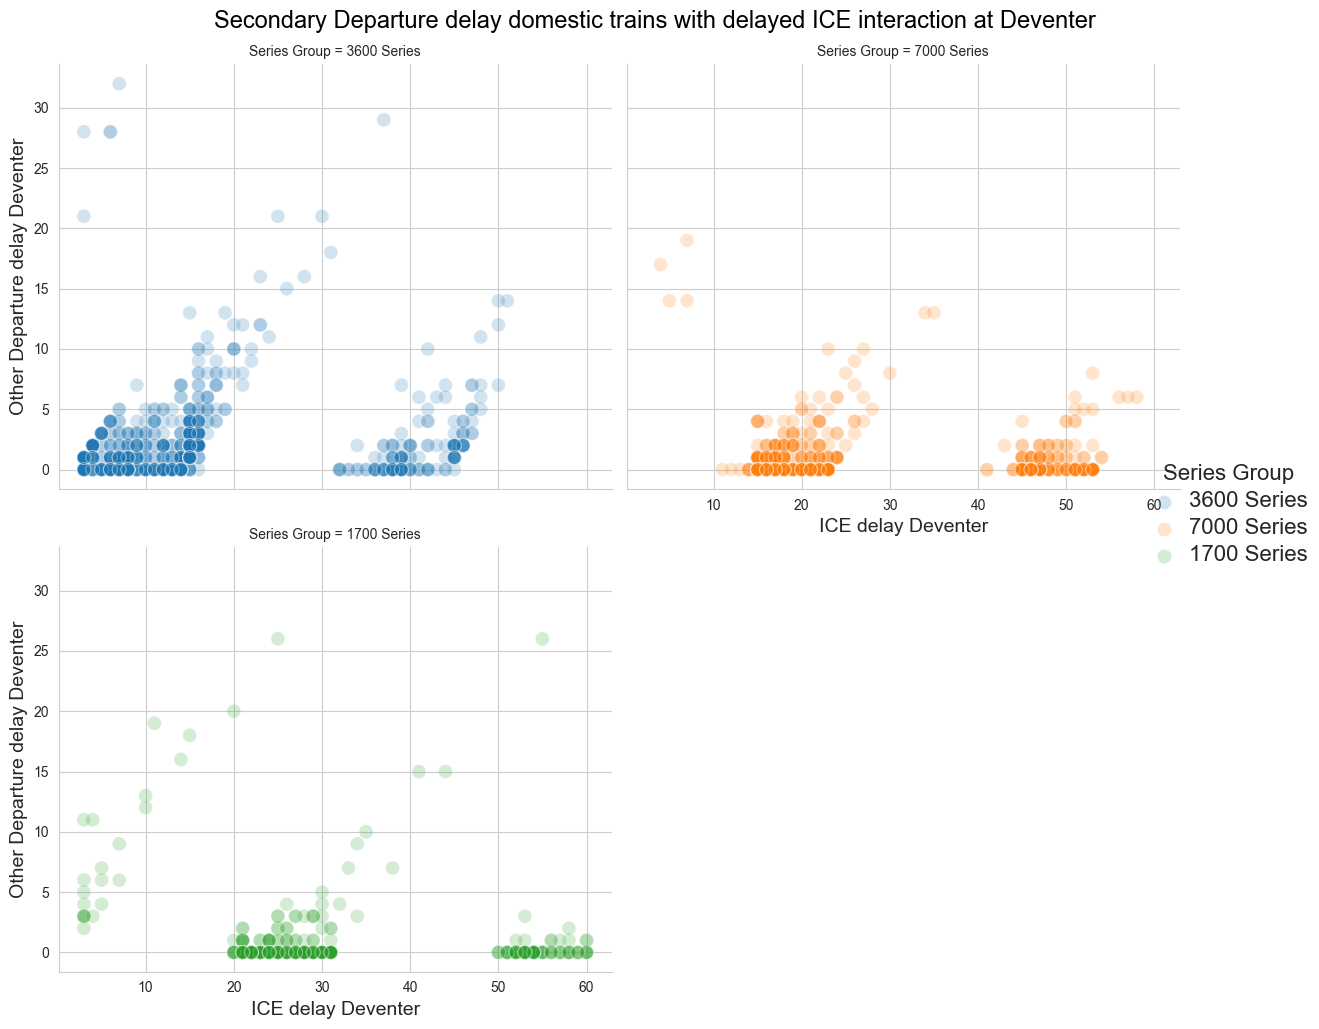

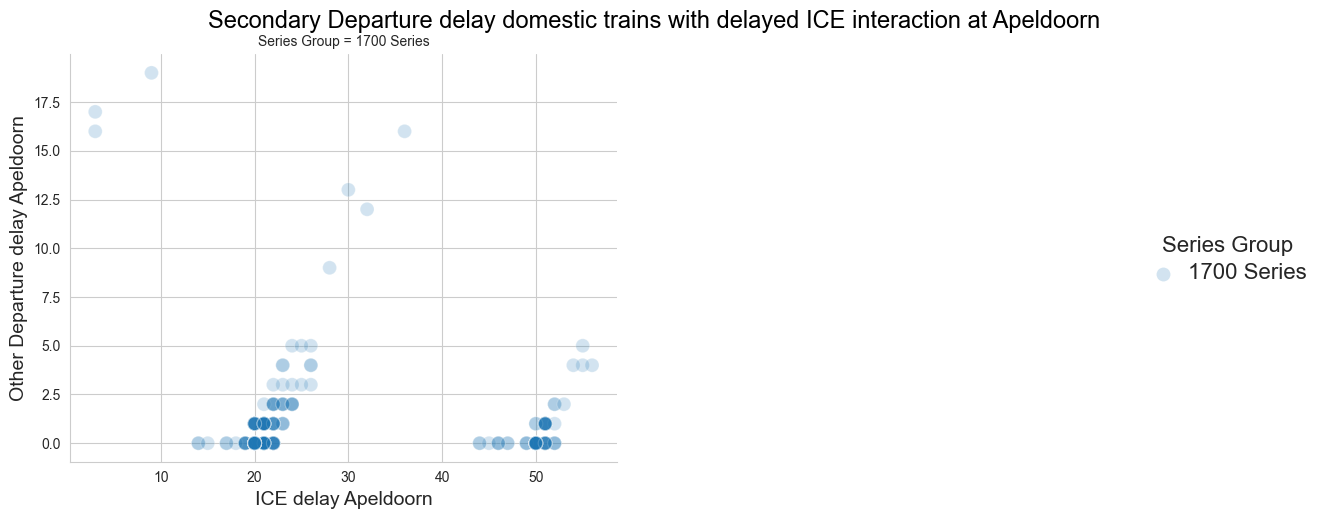

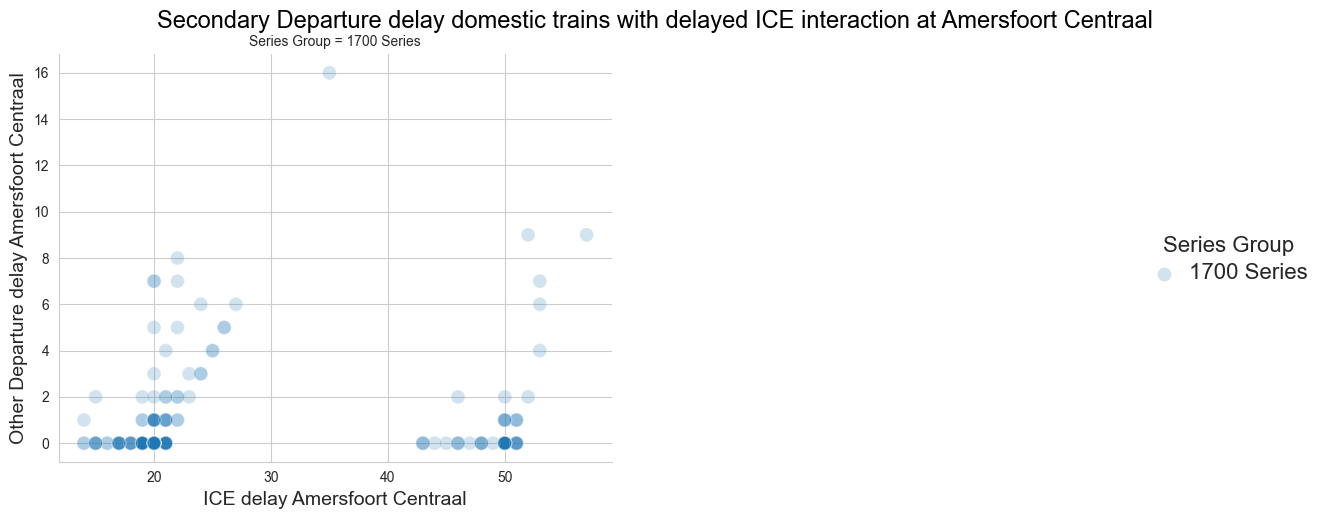

In [5]:
### INTERACTION AT STATIONS ###

headway = 3     #Average headway in NL
dwelltimes = {'Hengelo': 2, 'Deventer': 6, 'Apeldoorn':2, 'Amersfoort Centraal': 2}     #Dwell times of the ICE at the stops
delays = ['Arrival', 'Departure']   #Secondary delay for the arrival and departure of the domestic services are determined
delay_max = 60      #Only delays up to 60 minutes of the ICE are taken into account
no_interaction = df.copy()  

for delay in delays:  
    for i in stations:                                      #Dataframes are made per stations
        ICE_station = i                                     
        interaction_all_services = []                       #All interactions for every service + the delay of the ICE at Hengelo are added in this dataframe
        for x in ICE_services:                              #For every ICE service the interactions are identified
            ICE_H = df[                                     #Dataframe of the ICE data at the stop at which the secondary delay is related to, used for plotting the secondary delay
                (df['Service:Train number'] == x) &         #Train is the ICE service
                (df['Stop:Station name'] == ICE_station) &  
                (df['Service:Partly cancelled']==False) &   #Only non-canceled train
                (df[f'Stop:Arrival delay'] <= delay_max) &  #Only delays of the ICE smaller than the delay_max are considered
                (df[f'Stop:Arrival delay'] >= 3)            #Only delays of the ICE larger than 3 are considered
            ][['Service:Date', f'Stop:Arrival delay']]
            ICE = ICE_H.rename(columns={f'Stop:Arrival delay': f'ICE Delay {ICE_station}'})

            ice_time_at_station = df[                       #Dataframe of the ICE data at the considered station, used for determining the interaction
                (df['Service:Train number'] == x) &
                (df['Stop:Station name'] == i) &
                (df[f'Stop:Arrival delay'] >= 3)            #Only delays of the ICE larger than 3 are considered
            ][['Service:Date', f'Stop:Arrival time', f'Stop:Arrival delay']].rename(columns={f'Stop:Arrival time': f'ICE_Arrival_time'})
            ice_time_at_station[f'Actual_ICE_Arrival_Time_{i}'] = ice_time_at_station[f'ICE_Arrival_time'] + pd.to_timedelta(ice_time_at_station[f'Stop:Arrival delay'], unit = 'm')

            other_trains = df[                              #Dataframe of the domestic services
                (df['Service:Train number'] != x) & 
                (df['Stop:Station name'] == i)
            ][['Service:Date', 'Service:Train number', 'Stop:RDT-ID', f'Stop:{delay} time', f'Stop:{delay} delay']].rename(columns={f'Stop:{delay} delay': f'Other {delay} Delay {i}', f'Stop:{delay} time': f'Other_{delay}_time'})
            other_trains[f'Actual_Other_{delay}_Time_{i}'] = other_trains[f'Other_{delay}_time'] + pd.to_timedelta(other_trains[f'Other {delay} Delay {i}'], unit='m')

            ice_vs_allservices = pd.merge(other_trains, ice_time_at_station, on='Service:Date')   #Data of the domestic services and the ICE
            ice_vs_allservices['Time_Diff_Minutes'] = (ice_vs_allservices[f'Actual_Other_{delay}_Time_{i}'] - ice_vs_allservices[f'Actual_ICE_Arrival_Time_{i}']).dt.total_seconds() / 60 #Time difference between the arrival/departure of the domestic train and the arrival of the ICE

            if delay == "Arrival":
                interaction = ice_vs_allservices[(ice_vs_allservices['Time_Diff_Minutes'] >= - headway) & (ice_vs_allservices['Time_Diff_Minutes'] <= headway + dwelltimes[i])].copy()
            elif delay == 'Departure':
                interaction = ice_vs_allservices[(ice_vs_allservices['Time_Diff_Minutes'] >= -(headway + dwelltimes[i])) & (ice_vs_allservices['Time_Diff_Minutes'] <= headway)].copy()
            
            ice2_vs_allservices = pd.merge(interaction, ICE, on='Service:Date')
            interaction_all_services.append(ice2_vs_allservices)        #Data of the interaction of this ICE services added to the dataframe with all services

            ids_with_interaction = interaction['Stop:RDT-ID'].unique()
            no_interaction = no_interaction[~no_interaction['Stop:RDT-ID'].isin(ids_with_interaction)]  #Interactions are removed from the original dataframe, results is a dataframe with only data of domestic services without a delayed ICE interaction

        plot_data = pd.concat(interaction_all_services, ignore_index=True)  #interactions of all ICE services combined
        if plot_data.empty:
            continue
        plot_data['Series Group'] = plot_data['Service:Train number'].astype(str).str[:-2] + '00 Series'    #Only the first two or three numbers of the train series number identify the train service
        plot_data = plot_data[(plot_data['Series Group'] != '100 Series') & (plot_data['Series Group'] != '200 Series')  & (plot_data['Series Group'] != '20300 Series')& (plot_data['Series Group'] != '1500 Series')] #The ICE services, Eurobahn and IC Deventer-Amsterdam Centraal are removed from the data
        if delay == "Arrival":
            all_data_with_ICE_interaction[i] = plot_data    #

### Plotting the secondary delays per station per domestic service ###
        sns.set_style("whitegrid")
        g = sns.relplot(
            data=plot_data,
            x=f'ICE Delay {ICE_station}',
            y=f'Other {delay} Delay {i}',
            col='Series Group',           
            hue='Series Group',    
            kind='scatter',
            palette='tab10',
            height=5,                      
            aspect=1.2,                     
            s=100,
            alpha=0.2,
            col_wrap=2                     
        )

        legend = g.legend
        legend.set_title("Series Group", prop={'size': 16}) 

        for text in legend.get_texts():
            text.set_fontsize(16) 

        g.set_axis_labels(
            x_var=f'ICE delay {ICE_station}', 
            y_var=f'Other {delay} delay {i}', 
            fontsize=14 
        )
        g.fig.suptitle(f'Secondary {delay} delay domestic trains with delayed ICE interaction at {i}', y=1.02, fontsize = 17, color= 'black')
        plt.show()
        folder = "ICE Delay at station"
        save_path = os.path.join(folder, f"{i}, {delay} ({delay_max} min).png")
        g.figure.savefig(save_path, dpi=300, bbox_inches="tight")

        plt.close(g.figure)


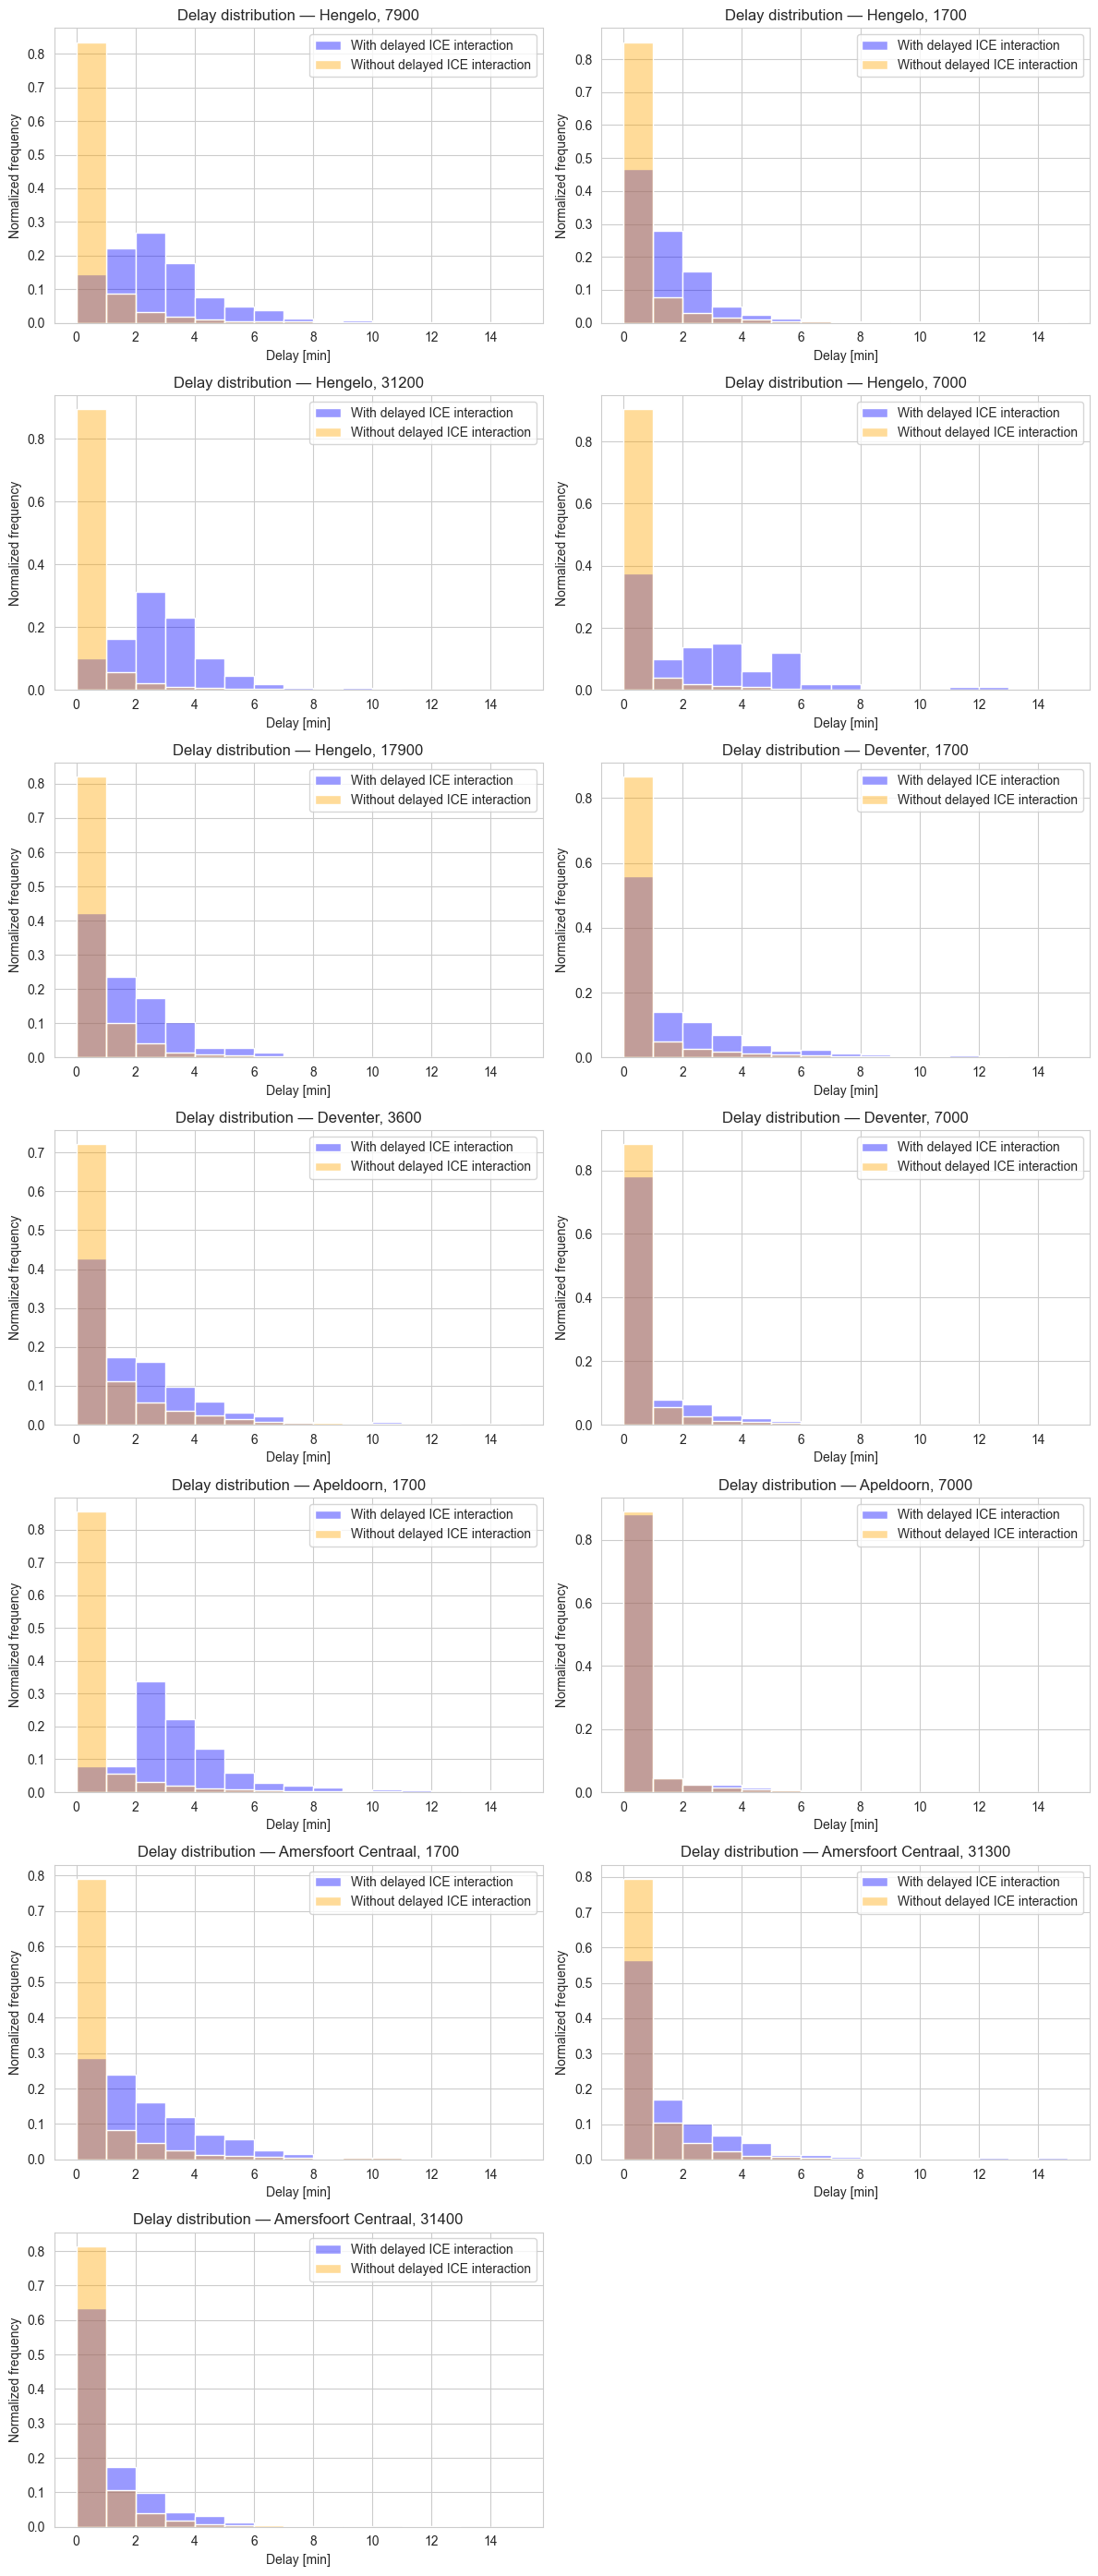

In [6]:
### DELAY DISTRIBUTION ###

# ---- Delay with ICE interaction ---- #
table = pd.DataFrame(columns = ['Station', 'Train series', 'Punctuality with ICE interaction'])
w_ICE = {}

for i in stations:
    df1 = all_data_with_ICE_interaction[i]
    for j in o_services:
        trainseries = j[:-2]
        filtered_df1 = df1[(df1['Service:Train number'].astype(str).str[:-2] == trainseries )] 
        if filtered_df1.empty:
            continue
        trains_delay = filtered_df1[f'Other Arrival Delay {i}'].tolist()

        w_ICE[f'{i}, {j}'] = trains_delay


# ---- Delay without ICE interaction ---- #
wo_ICE = {}
for i in stations:
    df1 = no_interaction[no_interaction['Stop:Station name'] == i]
    for j in o_services:
        trainseries = j[:-2]
        filtered_df1 = df1[(df1['Service:Train number'].astype(str).str[:-2] == trainseries ) ] 
        if filtered_df1.empty:
            continue
        trains_delay = filtered_df1['Stop:Arrival delay'].tolist()  
        wo_ICE[f'{i}, {j}'] = trains_delay

# ---- Visualization ---- #
keys = list(w_ICE.keys())
N = len(keys)
cols = 2
rows = int(np.ceil(N / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))

if N == 1:
    axes = np.array([axes])
else:
    axes = axes.flatten()

for i, key in enumerate(keys):
    ax = axes[i] 
    data1 = np.array(w_ICE[key], dtype=float)
    data2 = np.array(wo_ICE[key], dtype=float)

    data1 = data1[~np.isnan(data1)]
    data2 = data2[~np.isnan(data2)]

    if len(data1) == 0 and len(data2) == 0:
        ax.set_visible(False) 
        continue

    combined_data = np.concatenate([data1, data2])
    if combined_data.size > 0:
        min_val = 0
        max_val = 15
        bins = np.linspace(min_val, max_val, 16) 
    else:
        continue 

    sns.histplot(data1, ax=ax, bins=bins, stat="density", alpha=0.4, label="With delayed ICE interaction", color="blue")
    sns.histplot(data2, ax=ax, bins=bins, stat="density", alpha=0.4, label="Without delayed ICE interaction", color="orange")

    ax.set_xlabel("Delay [min]")
    ax.set_ylabel("Normalized frequency")
    ax.set_title(f"Delay distribution — {key}")
    ax.legend()
    ax.grid(True)

for i in range(N, rows * cols):
    axes[i].set_visible(False)

fig.tight_layout()
plt.savefig('Secondary_Delay_Distribution_Histogram.png') 



In [13]:
### MEAN PUNCTUALITY DIFFERENCE ###
table = pd.DataFrame(columns = ['Station', 'Train series', 'Punctuality with ICE interaction'])

# ---- with ICE ---- #
delay_def = 3
for i in stations:
    df = all_data_with_ICE_interaction[i]
    for j in o_services:
        trainseries = j[:-2]
        filtered_df1 = df[(df['Service:Train number'].astype(str).str[:-2] == trainseries )] 
        if filtered_df1.empty:
            continue
        total_trains = len(filtered_df1)
        trains_delay = (filtered_df1[f'Other Arrival Delay {i}'] >= delay_def).sum()
        share = 100-(int(trains_delay)/int(total_trains) * 100)
        data = [i,j, round(share, 1)]
        table.loc[len(table)] = data 
        
# ---- without ICE ---- #
for i in stations:
    df1 = no_interaction[no_interaction['Stop:Station name'] == i]
    for j in o_services:
        trainseries = j[:-2]
        filtered_df1 = df1[(df1['Service:Train number'].astype(str).str[:-2] == trainseries ) & (df1['Stop:Station name'] == i )] 
        if filtered_df1.empty:
            continue
        total_trains = len(filtered_df1)
        trains_delay = (filtered_df1[f'Stop:Arrival delay'] > delay_def).sum()  #A train is delayed is the delay is larger than the definition of a delay
        share = 100-(int(trains_delay)/int(total_trains) * 100)
        table.loc[(table['Station'] == i) & (table['Train series'] == j), 'Punctuality Overall'] = round(share, 1)

# ---- Result ---- #
table['Punctuality Difference'] = table['Punctuality with ICE interaction'] - table['Punctuality Overall']
table.to_excel(f'Impact of ICE Interaction on Mean Punctuality (Arrival) per Train Series.xlsx', index=False)
display(table)


# ---- Statistical test ---- #
for i in stations:
    df = all_data_with_ICE_interaction[i] # Data source 1 (station-specific)
    df1 = no_interaction[no_interaction['Stop:Station name'] == i]
    for j in o_services:
        trainseries = j[:-2]
        filtereddf1 = df[ (df['Service:Train number'].astype(str).str[:-2] == trainseries ) ]
        print(filtereddf1.columns)
        filtereddf2 = df1[ (df1['Service:Train number'].astype(str).str[:-2] == trainseries ) & (df1['Stop:Station name'] == i ) ]
        print(filtereddf2.columns)
        data1 = np.array(filtereddf1[f'Stop:Arrival delay'].tolist())
        data2 = np.array(filtereddf2[f'Stop:Arrival delay'].tolist())
        # --- OPTIMIZATION STEP 2: Check for valid data lengths ---
        if len(data1) < 2 or len(data2) < 2:
            continue 

        # t-test remains correct for comparing two independent, unequally-sized samples
        stat, p = mannwhitneyu(data1, data2, alternative='greater')
            
        print(f"Results: {i}, {j}")
        print(f"Test Statistic: {stat}")
        print(f"P-value: {p}")


,Station,Train series,Punctuality with ICE interaction,Punctuality Overall,Punctuality Difference
0,Hengelo,7900,63.3,96.9,-33.6
1,Hengelo,1700,90.0,97.3,-7.3
2,Hengelo,31200,57.7,97.9,-40.2
3,Hengelo,7000,60.8,97.3,-36.5
4,Hengelo,17900,82.8,97.6,-14.8
5,Deventer,1700,80.5,95.5,-15.0
6,Deventer,3600,75.8,92.1,-16.3
7,Deventer,7000,92.3,97.3,-5.0
8,Apeldoorn,1700,49.7,95.5,-45.8
9,Apeldoorn,7000,95.0,97.1,-2.1


Index(['Service:Date', 'Service:Train number', 'Stop:RDT-ID',
       'Other_Arrival_time', 'Other Arrival Delay Hengelo',
       'Actual_Other_Arrival_Time_Hengelo', 'ICE_Arrival_time',
       'Stop:Arrival delay', 'Actual_ICE_Arrival_Time_Hengelo',
       'Time_Diff_Minutes', 'ICE Delay Hengelo', 'Series Group'],
      dtype='object')
Index(['Service:RDT-ID', 'Service:Date', 'Service:Type', 'Service:Company',
       'Service:Train number', 'Service:Completely cancelled',
       'Service:Partly cancelled', 'Service:Maximum delay', 'Stop:RDT-ID',
       'Stop:Station code', 'Stop:Station name', 'Stop:Arrival time',
       'Stop:Arrival delay', 'Stop:Arrival cancelled', 'Stop:Departure time',
       'Stop:Departure delay', 'Stop:Departure cancelled',
       'Stop:Platform change', 'Stop:Planned platform',
       'Stop:Actual platform'],
      dtype='object')
Results: Hengelo, 7900
Test Statistic: nan
P-value: nan
Index(['Service:Date', 'Service:Train number', 'Stop:RDT-ID',
       'Other